In [5]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle

from astropy.io import fits
from astropy import wcs
import pickle

import sys
import imp
sys.path.insert(0, '/home/abrahamn/21cmIRxcor/')
import cat_utils
imp.reload(cat_utils)
from scipy.optimize import curve_fit
import scipy

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace
from scipy.linalg import sqrtm,inv

In [6]:
# LOAD LITERATURE IR POWER SPECTRA (Zemcov+ 14)

dat_dir = '../zemcov14_data/'
ell_Cell_ciber = np.genfromtxt(dat_dir+'zemcov14_CIBER_data_with_errors_Cl.txt',skip_header=4,delimiter=',')
ell_Cell_eormodel = np.genfromtxt(dat_dir+'zemcov14_eor_Cl.txt',skip_header=1,delimiter=',')

# these are in nW/m^2/sr, but I want to convert them to kJy/sr
# I have to divide by the bandwidth of 0.5um
lamda_m = 1.1e-6
freq_Hz = 3.e8/lamda_m
convert_to_kJy_per_sr = 1.e-9/freq_Hz/(1.e3*1.e-26)

ell_Cell_ciber[:,1] *= convert_to_kJy_per_sr
ell_Cell_eormodel[:,1] *= convert_to_kJy_per_sr

In [7]:
labels = '02a57694o0299I 02a57694o0303I 02a57694o0307I 02a57694o0319I 02a57694o0323I 02a57694o0327I 02a57694o0339I 02a57694o0343I 02a57694o0347I'.split()
analysis_name = '_'.join([l.split('o')[1] for l in labels])
print(analysis_name)

run = 'ATLAS_mwa57694_rereduction'
xcor_data_dir = '/home/abrahamn/xcor_data/'
raw_frames_root = xcor_data_dir+run+'/'
analysis_root = xcor_data_dir+'analysis/'+run+'/' + analysis_name + '/'

0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I


In [8]:
secat = cat_utils.IRCatalog(se_path=analysis_root+analysis_name+'.sex',se_magzpt=20.46)
g = secat.jy_all>1.e-10
secat = cat_utils.Catalog(secat.ra_all[g],secat.dec_all[g],secat.jy_all[g],a=secat.a[g],b=secat.b[g])

loading/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I.sex


In [ ]:
img_fits_path = analysis_root+analysis_name+'.fits'

hdulist_img = fits.open(img_fits_path)
img = hdulist_img[0].data
h = hdulist_img[0].header
n = img.shape[0]
hdulist_img.close()

x,y = np.where(img != 0)

x_med, y_med = np.median(x),np.median(y)

In [ ]:
img_fits_path = analysis_root+analysis_name+'.fits'
hdulist_img = fits.open(img_fits_path)
img = hdulist_img[0].data
h = hdulist_img[0].header
n = img.shape[0]
hdulist_img.close()
w = wcs.WCS(h)
asec_per_pixel = np.abs(h['CD1_1'])*3600

In [ ]:
def mask_circle_in_image(m,xcent,ycent,r):    
    if r == 0: return
    
    n=m.shape[0]
    if not ((0<=xcent<n) and (0<=ycent<n)): return
    for y in range(-int(r),int(r)+1): # x is the x distance from circle center
        if not (0 <= ycent+y < n): continue
        #print(n)
        #print(int(xcent-np.sqrt(r**2-y**2)),int(xcent+np.sqrt(r**2-y**2)))
        #rint(max(0,int(xcent-np.sqrt(r**2-y**2))),min(n,int(xcent+np.sqrt(r**2-y**2))),)
        m[ycent+y,max(0,int(xcent-np.sqrt(r**2-y**2))):min(n,int(xcent+np.sqrt(r**2-y**2)))] = 0
        
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,min_fraction_unmasked=.5,gauss_fit_min=.1,bin_method='fit'): # or 'avg'
    img_binned = np.zeros((n_coarse,n_coarse))
    
    binedges = np.linspace(300,400,200) # for the hist gaussian fitting
    
    print(bin_method)
    
    for i in range(n_coarse):
        if i % 15 == 0: print('%1.3f '%(1.*i/n_coarse)),
        for j in range(n_coarse):
            img_in_this_coarse_bin = img[i*coarse_bin_factor:(i+1)*coarse_bin_factor,j*coarse_bin_factor:(j+1)*coarse_bin_factor]
            mask_in_this_coarse_bin = mask[i*coarse_bin_factor:(i+1)*coarse_bin_factor,j*coarse_bin_factor:(j+1)*coarse_bin_factor]
            if np.any(img_in_this_coarse_bin==0) or np.sum(mask_in_this_coarse_bin)<min_fraction_unmasked*coarse_bin_factor**2: continue

            unmasked_img_vals = img_in_this_coarse_bin[1==mask_in_this_coarse_bin]
                
            if bin_method == 'avg':
                img_binned[i,j] = np.mean(unmasked_img_vals)
            elif bin_method == 'fit':
                counts,binedges = np.histogram(unmasked_img_vals,binedges)
                bins = .5*(binedges[1:]+binedges[:-1])
                g = counts>np.max(counts)*gauss_fit_min

                try:
                    coeff, var_matrix = curve_fit(gauss, bins[g], counts[g],\
                                                  p0=[np.max(counts),np.median(img_in_this_coarse_bin[1==mask_in_this_coarse_bin]),10],\
                                                  sigma=np.sqrt(counts[g]))
                    img_binned[i,j] = coeff[1]
                except:
                    pass
    return img_binned

In [ ]:
def make_hann_2D(n):
    w = scipy.signal.hann(n)
    wx,wy = np.meshgrid(w,w)
    w2 = wx*wy
    return w2, sqrt(np.mean(w2**2))

def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def vec2arr(v):
    return np.array(v).flatten()

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True,filt_small_lx_and_ly_bins=False):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)

    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
    lx,ly = meshgrid(lvals,lvals)
    dl = np.abs(lvals[1]-lvals[0])
    lmag  = sqrt(lx**2+ly**2)
    print(np.max(lmag))

    wind,windrms = np.ones((n,n)),1
    if usehann: wind,windrms = make_hann_2D(n)
    img_ft = fft.fft2((img-img.mean())*wind)/windrms
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        if filt_small_lx_and_ly_bins: inbin &= (np.abs(lx)>2*dl)&(np.abs(ly)>2*dl)
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

def img2optPS(img_meas,pguess_method,dtheta_rad,nbins,lmin,lmax,uselogbins=True,interp_pguess=False,verbose=False,filt_small_lx_and_ly_bins=False):
    n = img_meas.shape[0]
    norm = (dtheta_rad**2)/(n**2)*n**4
    xir = matrix(img_meas.flatten()).T

    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=uselogbins)

    lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
    dl = np.abs(lvals[1]-lvals[0])
    print('\ndl = %d'%(lvals[1]-lvals[0]))
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)

    if verbose:
        for bini in range(nbins):
            if filt_small_lx_and_ly_bins:
                smallell = (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])&smallell),lbincenters[bini]))
            else:
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])),lbincenters[bini]))
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    def gen_Ccommabini(bini):
        inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
        if filt_small_lx_and_ly_bins: inbin &= (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
        ivals_inbin,jvals_inbin = where(inbin)

        lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
        Ccommabini_0 = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = Ccommabini_0*conj(Ccommabini_0.T)
        return Ccommabini
    #Ccomma_mats = [gen_Ccommabini(bini) for bini in range(nbins)]


    # put in a guess of the data covariance
    print('a '),
    # generate the fourier transform matrix
    lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
    lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
    F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))/n**2
    
    if pguess_method == 'zemcov':
        pguess = np.interp(lbincenters,ell_Cell_ciber[1::3,0],ell_Cell_ciber[1::3,1]**2/ell_Cell_ciber[1::3,0]**2)
    else:
        pguess = 1./lbincenters**pguess_method
    
    Cguess_ft = matrix(np.diag( 10.**np.interp(np.log10(lmaggrid.flatten()),np.log10(lbincenters),np.log10(pguess/norm/n**2)) ))   
    Csignal = F*Cguess_ft*conj(F).T
            
    print('c '),
    Cmask = 1.e5*np.matrix(np.diag(img_meas.flatten()==0)) # IS THIS A REASONABLE NUMBER ??
    print('d '),
    Cinv = inv(Csignal + Cmask)

    print('e '),
    # calculate q_alpha
    q = np.matrix(np.zeros((nbins,1)))
    Ccomma_times_Cinv_mats = []
    print('\nbins: '),
    for bini in range(nbins):
        print(bini),
        Ccommabini_times_Cinv = gen_Ccommabini(bini)*Cinv
        Ccomma_times_Cinv_mats.append(Ccommabini_times_Cinv)
        q[bini] = .5*real(xir.T*Cinv*Ccommabini_times_Cinv*xir).item()

    # calculate Fisher matrix

    Fish = np.matrix(np.zeros((nbins,nbins)))
    print('\nfisher row: '),
    for i in range(nbins):
        print(i),
        for j in range(i,nbins):
            Fish[i,j] = np.real(.5*trace(Ccomma_times_Cinv_mats[i]*Ccomma_times_Cinv_mats[j]))
            Fish[j,i] = Fish[i,j]
    
    p0 = vec2arr(sqrtm(inv(Fish))*q)*norm/vec2arr(np.max(sqrt(Fish),axis=0))
    p1 = vec2arr(inv(Fish)*q*norm)

    return lbincenters,p0,Fish

In [ ]:
def rawimg2pspec(img,mask_coef1=10,mask_coef2=12,mask_above_median_adu_plus=1.e9,\
             target_coarse_res_amin=3.5,min_fraction_unmasked=.5,gauss_fit_min=.1,\
             fov_deg=4.,ps_method='oqe',filt_small_lx_and_ly_bins=True,lmin=350,lmax=4360,nbins=8,\
             uselogbins=True,use_fft_hann=True,masked_img_zoom_skip=1,bin_method='avg',pguess_method='zemcov'):
    
    mask = np.ones(img.shape)
    px,py = w.wcs_world2pix(secat.ra,secat.dec,1)

    print('masking sources')
    for i in range(len(secat.ra)):
        if i % 2500 == 0: print('%1.3f '%(1.*i/len(secat.ra))),
        mask_circle_in_image(mask,px[i],py[i],mask_coef1*secat.jy[i]/asec_per_pixel+mask_coef2*min(secat.a[i],secat.b[i]))
        
    
    mask *= img < mask_above_median_adu_plus + np.median(img[img>0]) # to active this, set mask_above_median_adu_plus = 10    
    
    dd = 300
    x0,x1 = x_med-dd,x_med+dd
    y0,y1 = y_med-dd,y_med+dd
    skip = masked_img_zoom_skip
    masked_img_zoom = img[x0:x1:skip,y0:y1:skip]*mask[x0:x1:skip,y0:y1:skip]
    
    target_coarse_res_asec = target_coarse_res_amin*60
    fine_pixel_asec = 1.86
    coarse_bin_factor = int(np.round(target_coarse_res_asec/fine_pixel_asec))
    dtheta_coarse_rad = fine_pixel_asec*coarse_bin_factor/3600*np.pi/180

    n_coarse = int(np.floor(1.*n/coarse_bin_factor))
    n_fine_max = n_coarse*coarse_bin_factor
    print('n_coarse = %d, coarse_bin_factor = %d'%(n_coarse,coarse_bin_factor))
    
    print('binning image')
    img_coarse = bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,min_fraction_unmasked,gauss_fit_min,bin_method=bin_method)
    
    d = int(fov_deg*np.pi/180/dtheta_coarse_rad)
    dtheta_rad = fine_pixel_asec/3600*np.pi/180
    x0 = int(x_med*dtheta_rad/dtheta_coarse_rad-d/2+1)
    x1 = x0+d
    y0 = int(y_med*dtheta_rad/dtheta_coarse_rad-d/2+1)
    y1 = y0+d

    magzpt,exp_time_sec = 20.56,30
    adu2jy_per_sr = 3.631*(10**(-magzpt/2.5))/exp_time_sec/dtheta_coarse_rad**2*coarse_bin_factor**2

    img_kjy_per_sr = adu2jy_per_sr*img_coarse[x0:x1,y0:y1]
    img_kjy_per_sr_meansub = np.array(img_kjy_per_sr)
    img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0] -= np.mean(img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0])

    if ps_method == 'oqe':
        print('\ncomputing power spectrum with OQE')
        lbins,pspec,Fish = img2optPS(img_kjy_per_sr_meansub,pguess_method,dtheta_coarse_rad,nbins,lmin,lmax,\
                                  uselogbins=uselogbins,interp_pguess=True,verbose=True,\
                                  filt_small_lx_and_ly_bins=filt_small_lx_and_ly_bins)
    elif ps_method == 'fft':
        print('\ncomputing power spectrum with FFT')
        lbins,pspec,bin_counts = img2PS(img_kjy_per_sr_meansub,dtheta_coarse_rad,nbins,lmin,lmax,\
                                     uselogbins=True,usehann=use_fft_hann,\
                                     filt_small_lx_and_ly_bins=filt_small_lx_and_ly_bins)
    
    print('done')
    return lbins,pspec,img_kjy_per_sr_meansub,masked_img_zoom

In [ ]:
nbins = 5

lbins_pspec_img_zoom_list = []

lbins_pspec_img_zoom_list.append(rawimg2pspec(img,mask_coef1=10,mask_coef2=12,mask_above_median_adu_plus=10.,\
             min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=True,pguess_method='zemcov',nbins=nbins))

lbins_pspec_img_zoom_list.append(rawimg2pspec(img,mask_coef1=10,mask_coef2=12,mask_above_median_adu_plus=10.,\
             min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=False,pguess_method='zemcov',nbins=nbins))

lbins_pspec_img_zoom_list.append(rawimg2pspec(img,mask_coef1=10,mask_coef2=5,mask_above_median_adu_plus=1.e9,\
             min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=False,pguess_method='zemcov',nbins=nbins))

lbins_pspec_img_zoom_list.append(rawimg2pspec(img,mask_coef1=10,mask_coef2=0,mask_above_median_adu_plus=1.e9,\
             min_fraction_unmasked=.1,ps_method='fft',filt_small_lx_and_ly_bins=False,pguess_method='zemcov',nbins=nbins))

In [9]:
#pickle.dump( lbins_pspec_img_zoom_list, open( "lbins_pspec_img_zoom_list.p", "wb" ) )
lbins_pspec_img_zoom_list = pickle.load(open( "lbins_pspec_img_zoom_list.p", "rb" ) )

In [14]:
ell_Cell_eormodel

array([[  9.84532316e+01,   1.58979923e-02],
       [  1.44335776e+02,   1.97379486e-02],
       [  2.38801465e+02,   2.77302012e-02],
       [  4.19549901e+02,   3.44280759e-02],
       [  7.51876748e+02,   3.77729765e-02],
       [  1.32088188e+03,   4.54692846e-02],
       [  2.61702105e+03,   4.54692846e-02],
       [  4.88211706e+03,   4.83686269e-02],
       [  9.11139776e+03,   6.19364499e-02],
       [  1.73638945e+04,   1.14921870e-01],
       [  2.99093302e+04,   1.66523876e-01],
       [  5.25760294e+04,   2.64739529e-01],
       [  9.42980052e+04,   4.20882699e-01]])

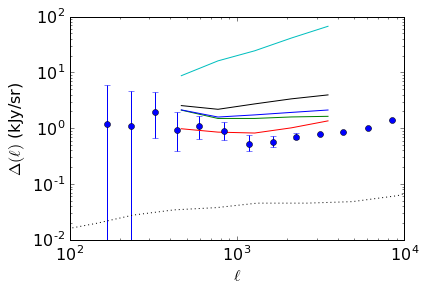

In [16]:
stys = ['r','g-','b-','k-','c-']
matplotlib.rcParams.update({'font.size': 16})

for i in range(len(lbins_pspec_img_zoom_list)):
    lbins,pspec,img_kjy_per_sr_meansub,masked_img_zoom = lbins_pspec_img_zoom_list[i]
    plt.loglog(lbins,sqrt(lbins**2*pspec/(2*pi)),stys[i])

plt.errorbar(ell_Cell_ciber[1::3,0],ell_Cell_ciber[1::3,1],yerr=[np.abs(ell_Cell_ciber[1::3,1]-ell_Cell_ciber[0::3,1]),\
                                                                 np.abs(ell_Cell_ciber[2::3,1]-ell_Cell_ciber[1::3,1])],fmt='o')

plt.loglog(ell_Cell_eormodel[:,0],ell_Cell_eormodel[:,1],'k:')

plt.ylim([.01,100])
plt.xlim([100,1.e4])
plt.xlabel('$\ell$')
plt.ylabel('$\Delta(\ell)$ (kJy/sr)')

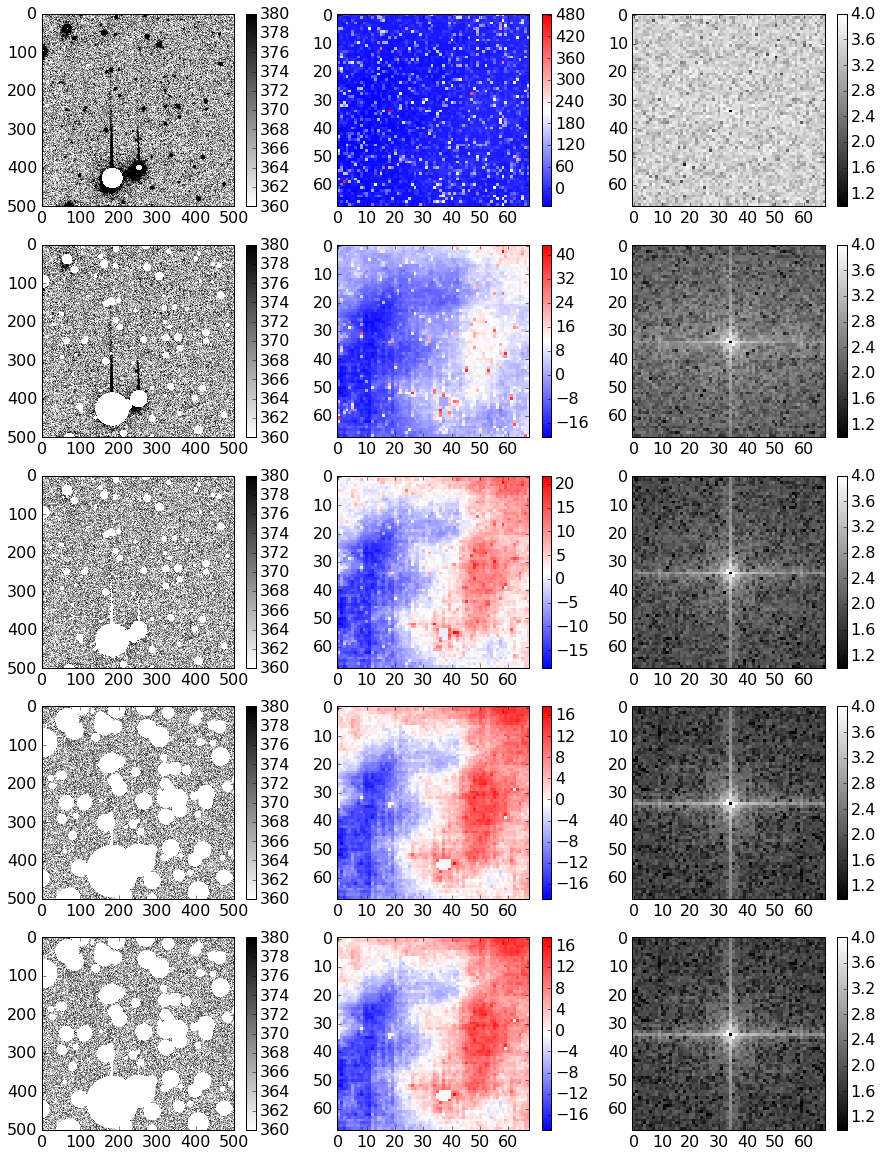

In [19]:
plt.figure(figsize=(15,20))

num_paramsets = len(lbins_pspec_img_zoom_list)
for i in range(num_paramsets):
    lbins,pspec,img_kjy_per_sr_meansub,masked_img_zoom = lbins_pspec_img_zoom_list[num_paramsets-i-1]
    
    plt.subplot(num_paramsets,3,3*i+1)
    plt.imshow(masked_img_zoom[200:700,200:700],vmin=360,vmax=380,interpolation='nearest',cmap='gray_r')
    plt.colorbar()

    plt.subplot(num_paramsets,3,3*i+2)
    plt.imshow(img_kjy_per_sr_meansub,interpolation='nearest',cmap='bwr')
    plt.colorbar()

    plt.subplot(num_paramsets,3,3*i+3)
    plt.imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(img_kjy_per_sr_meansub)))),\
               interpolation='nearest',cmap='gray',vmin=1,vmax=4)
    plt.colorbar()